In [1]:
# Converts a dataBatch (iterable of [image_batch, label_batch]) 
# into a tuple of two lists: one list of image batches, another of corresponding label batches.
def from_DataBatch_to_list(dataBatch):
  val_dataset2 = []  # list to collect image batches
  val_dataset2_gt = []  # list to collect ground truth batches
  i = 0  # index counter for elements within batch (0: images, 1: labels)

  # Iterate over each batch in the provided dataBatch
  for batch in dataBatch:
    # Each batch is expected to be a sequence where index 0 is images and index 1 is labels
    for i in range(len(batch)):
      if i == 0:
        val_dataset2.append(batch[i])  # append image batch
      if i == 1:
        val_dataset2_gt.append(batch[i])  # append label batch
    
  # Return a tuple (images_list, labels_list)
  return (val_dataset2, val_dataset2_gt)


In [2]:
import torch

def topk_accuracy(model, k, validation_tuple, device=None):
    """
    Compute Top-K accuracy for a PyTorch model over a validation dataset.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        k (int): Number of top predictions to consider for accuracy.
        validation_tuple (tuple): A tuple (val_data, val_labels), where
            - val_data is a list of input batches (torch.Tensor) of shape [B, C, H, W]
            - val_labels is a list of corresponding label batches, either as class indices [B]
        device (torch.device, optional): Device to run inference on. If None, uses CUDA if available.

    return:
        float: Top-K accuracy over the entire validation set.
    """
    # Unpack validation data and labels
    val_data, val_labels = validation_tuple

    # Select device: use GPU if available and not specified
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval()

    correct = 0  # Counter for correctly predicted samples
    total = 0    # Counter for total samples

    # Disable gradient computation for inference
    with torch.no_grad():
        # Iterate over batches of inputs and labels
        for x_batch, y_batch in zip(val_data, val_labels):
            # Move batch to the selected device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass: obtain raw logits of shape [B, num_classes]
            outputs = model(x_batch)

            # Get the indices of the top-k predictions for each sample [B, k]
            topk_inds = outputs.topk(k, dim=1).indices

            # If labels are one-hot encoded, convert to class indices
            if y_batch.dim() > 1:
                y_true = y_batch.argmax(dim=1)
            else:
                y_true = y_batch  # Already class indices

            # Compare true labels against top-k predictions: [B, k] boolean tensor
            matches = topk_inds.eq(y_true.unsqueeze(1))

            # Count samples where the true label is among the top-k predictions
            correct += matches.any(dim=1).sum().item()
            total += x_batch.size(0)

    # Return the ratio of correct predictions
    return correct / total


In [3]:
import torch

def confusion_matrix(model, failure_types, validation_tuple, thresholds, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device).eval()
    
    val_batches, label_batches = validation_tuple
    C = len(failure_types)
    defect_classes = C - 1  # 'none' 인덱스
    
    all_true = []
    all_pred = []
    all_prob = []
    
    with torch.no_grad():
        for x_batch, y_batch in zip(val_batches, label_batches):
            x = x_batch
            # --- 입력 차원 보정 ---
            # 3D: (H, W, C) → (1, C, H, W)
            if isinstance(x, torch.Tensor) and x.dim() == 3:
                if x.shape[-1] == 3:
                    x = x.permute(2, 0, 1).contiguous()
                x = x.unsqueeze(0)
            # 4D NHWC: (B, H, W, C) → (B, C, H, W)
            elif isinstance(x, torch.Tensor) and x.dim() == 4 and x.shape[-1] == 3:
                x = x.permute(0, 3, 1, 2).contiguous()
            
            x = x.to(device).float()
            logits = model(x)                      
            probs  = torch.softmax(logits, dim=1)  
            
            # --- 레이블 정리 ---
            if isinstance(y_batch, torch.Tensor):
                y = y_batch.to(device)
                if y.dim() > 1:
                    y_list = y.argmax(dim=1).cpu().tolist()
                else:
                    y_list = y.cpu().tolist()
            elif isinstance(y_batch, (list, tuple)):
                y_list = list(y_batch)
            else:
                y_list = [int(y_batch)]
            
            all_true.extend(y_list)
            
            # defect 클래스 중 top-k=1 예측
            top_probs, top_idx = probs[:, :defect_classes].max(dim=1)
            all_pred.extend(top_idx.cpu().tolist())
            all_prob.extend(top_probs.cpu().tolist())
    
    # --- 혼동행렬 만들기 ---
    if thresholds:
        cms = []
        for thr in thresholds:
            cm = [[0]*C for _ in range(C)]
            for t, p, prob in zip(all_true, all_pred, all_prob):
                pred_idx = p if prob > thr else (C-1)
                cm[t][pred_idx] += 1
            cms.append(cm)
        return cms
    else:
        cm = [[0]*C for _ in range(C)]
        for t, p in zip(all_true, all_pred):
            cm[t][p] += 1
        return cm


In [4]:
def classes_proportion_correctly_classified(c_matrix, failure_types):
  dict_ = {}
  for i in range(len(failure_types)):
    dict_[failure_types[i]] = c_matrix[i][i]/np.sum(c_matrix[i])
  
  return dict_

In [5]:
def metrics_report(c_matrix):
  precision = 0
  recall = 0

  num = 0
  precision_den = 0
  recall_den = 0

  for i in range(len(c_matrix)):
  # Index 8 is assumed to represent the negative class
    if (i != 8):
      num += c_matrix[i][i]
      precision_den += c_matrix[i][i] + c_matrix[8][i]
      recall_den += c_matrix[i][i] + c_matrix[i][8]
    

  precision = num/precision_den
  recall = num/recall_den
  return (
      {'precision': precision, 
       'recall': recall,
       'f1-measure': 2*(precision*recall)/(precision+recall)})

In [6]:
def roc_auc_report(confusion_matrixes):
  tp_rates = []
  fp_rates = []

  for l in range(len(confusion_matrixes)):
    tp = 0; fn = 0
    fp = 0; tn = 0

    cm = confusion_matrixes[l]

    for i in range(len(cm)):
      if (i != 8):
        tp += cm[i][i] 
        fn += cm[i][8]
        fp += cm[8][i]
      
      if (i == 8):
        tn = cm[i][i]
  
    tp_rates.append(tp/(tp+fn))
    fp_rates.append(fp/(fp+tn))

  return (tp_rates, fp_rates)

In [7]:
import copy
import matplotlib.pyplot as plt

def roc_curve(tp_rates, fp_rates):
  tp = copy.deepcopy(tp_rates)
  #tp.extend([0])
  tp.reverse()

  fp = copy.deepcopy(fp_rates)
  #fp.extend([0])
  fp.reverse()

  plt.plot(fp, tp)
  plt.plot([0, 1], ls="--")
  plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  plt.xlabel("false positive rate") 
  plt.ylabel("true positive rate")
  plt.title("ROC curve")

In [8]:
import numpy as np

threshold1 = np.arange(0, 1, 0.01).tolist()
threshold2 = []

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

val_dir        = 'C://Users/isang/OneDrive/Desktop/WM/data/WM811K_val'
test_dir       = 'C://Users/isang/OneDrive/Desktop/WM/data/WM811K_test'
train_aug_dir  = 'C://Users/isang/OneDrive/Desktop/WM/data/WM811K_train_aug'

transform = transforms.Compose([
    transforms.Resize((53, 52)),
    transforms.ToTensor(),
])

batch_size = 32
num_workers = 4
pin_memory = True


val_dataset       = datasets.ImageFolder(val_dir,       
                                         transform=transform)
test_dataset      = datasets.ImageFolder(test_dir,      
                                         transform=transform)
train_aug_dataset = datasets.ImageFolder(train_aug_dir, 
                                         transform=transform)

val_loader       = DataLoader(val_dataset,       
                              batch_size=batch_size, 
                              shuffle=True,  
                              num_workers=num_workers, 
                              pin_memory=pin_memory)

test_loader      = DataLoader(test_dataset,      
                              batch_size=batch_size, 
                              shuffle=True,  
                              num_workers=num_workers, 
                              pin_memory=pin_memory)

train_aug_loader = DataLoader(train_aug_dataset, 
                              batch_size=batch_size, 
                              shuffle=True,  
                              num_workers=num_workers, 
                              pin_memory=pin_memory)


## Model6 L2 Regularization

In [10]:
import torch
import torch.nn as nn

from torchsummary import summary

class Model6(nn.Module):
    def __init__(self, num_classes=9):
        super(Model6, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=3, padding=1),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=3, padding=1),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.AdaptiveMaxPool2d((1, 1))
            )
        
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(128, num_classes)
        
        self._init_weights()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

model6 = Model6(num_classes=9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(model6, input_size=(3, 53, 52), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 53, 52]             896
       BatchNorm2d-2           [-1, 32, 53, 52]              64
              ReLU-3           [-1, 32, 53, 52]               0
         MaxPool2d-4           [-1, 32, 18, 18]               0
            Conv2d-5           [-1, 64, 18, 18]          18,496
       BatchNorm2d-6           [-1, 64, 18, 18]             128
              ReLU-7           [-1, 64, 18, 18]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
      BatchNorm2d-10            [-1, 128, 6, 6]             256
             ReLU-11            [-1, 128, 6, 6]               0
AdaptiveMaxPool2d-12            [-1, 128, 1, 1]               0
           Linear-13                    [-1, 9]           1,161
Total params: 94,857
Trainable params: 

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model6 = Model6(num_classes=9).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model6.parameters(), lr=1e-4, weight_decay=1e-4)

num_epochs = 100

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0


history6 = {
    "loss": [],
    "accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

for epoch in range(1, num_epochs + 1):
    model6.train()
    running_loss = running_corrects = running_total = 0

    for imgs, labels in train_aug_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model6(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss    += loss.item() * batch_size
        preds = logits.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        running_total   += batch_size

    epoch_loss = running_loss / running_total
    epoch_acc  = running_corrects / running_total
    history6["loss"].append(epoch_loss)
    history6["accuracy"].append(epoch_acc)

    model6.eval()
    val_loss = val_corrects = val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model6(imgs)
            loss = criterion(logits, labels)

            bs = imgs.size(0)
            val_loss     += loss.item() * bs
            preds        = logits.argmax(dim=1)
            val_corrects += (preds == labels).sum().item()
            val_total   += bs

    epoch_val_loss = val_loss / val_total
    epoch_val_acc  = val_corrects / val_total
    history6["val_loss"].append(epoch_val_loss)
    history6["val_accuracy"].append(epoch_val_acc)

    print(f'Epoch {epoch}/{num_epochs}  '
          f'Train Loss: {epoch_loss:.4f}  Train Acc: {epoch_acc:.4f}  '
          f'Val Loss: {epoch_val_loss:.4f}  Val Acc: {epoch_val_acc:.4f}')

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        # Update best validation loss and reset counter
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model6.state_dict(), 'best_model.pth')
    # If no improvement, increment the counter
    else:
        # No improvement in validation loss
        epochs_no_improve += 1
        print(epochs_no_improve)
        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            break

Epoch 1/100  Train Loss: 0.2927  Train Acc: 0.9096  Val Loss: 0.1107  Val Acc: 0.9666
Epoch 2/100  Train Loss: 0.1485  Train Acc: 0.9493  Val Loss: 0.1200  Val Acc: 0.9653
1
Epoch 3/100  Train Loss: 0.1238  Train Acc: 0.9573  Val Loss: 0.0934  Val Acc: 0.9709
Epoch 4/100  Train Loss: 0.1089  Train Acc: 0.9618  Val Loss: 0.1122  Val Acc: 0.9668
1
Epoch 5/100  Train Loss: 0.0979  Train Acc: 0.9654  Val Loss: 0.0793  Val Acc: 0.9750
Epoch 6/100  Train Loss: 0.0895  Train Acc: 0.9684  Val Loss: 0.0896  Val Acc: 0.9726
1
Epoch 7/100  Train Loss: 0.0827  Train Acc: 0.9709  Val Loss: 0.0788  Val Acc: 0.9748
Epoch 8/100  Train Loss: 0.0763  Train Acc: 0.9732  Val Loss: 0.0788  Val Acc: 0.9747
Epoch 9/100  Train Loss: 0.0715  Train Acc: 0.9746  Val Loss: 0.0785  Val Acc: 0.9747
Epoch 10/100  Train Loss: 0.0666  Train Acc: 0.9767  Val Loss: 0.0924  Val Acc: 0.9700
1
Epoch 11/100  Train Loss: 0.0623  Train Acc: 0.9782  Val Loss: 0.0778  Val Acc: 0.9752
Epoch 12/100  Train Loss: 0.0583  Train Acc:

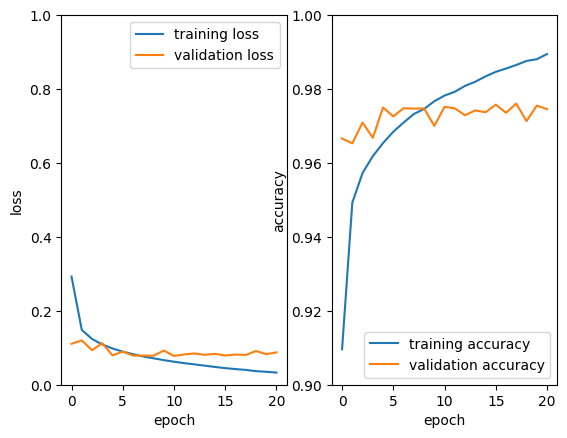

In [12]:
plt.subplot(1,2,1)
plt.plot(history6['loss'])
plt.plot(history6['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history6['accuracy'])
plt.plot(history6['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.9, 1])
plt.legend(['training accuracy', 'validation accuracy'])

In [13]:
failure_types = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]

val_dataset = torch.load("C://Users/isang/OneDrive/Desktop/WM/data/Val.pt")
val_tuple = from_DataBatch_to_list(val_dataset)

cm2 = confusion_matrix(model6, failure_types, val_tuple, threshold2)
p = classes_proportion_correctly_classified(cm2, failure_types)

print(p)

print(f"Mean Proportion : {np.mean(list(p.values()))}")


{'Center': 0.9693430656934306, 'Donut': 0.9438202247191011, 'Edge-Loc': 0.8971499380421314, 'Edge-Ring': 0.9948253557567918, 'Loc': 0.8362989323843416, 'Near-full': 0.9166666666666666, 'Random': 0.9057971014492754, 'Scratch': 0.8, 'none': 0.0}
Mean Proportion : 0.8071001427457487


In [14]:
import os
import torch

save_dir = r"C:\Users\isang\OneDrive\Desktop\WM\models"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "model6.pth")
torch.save(model6.state_dict(), save_path)